### Config

In [1]:
import os
import sys
PROJ_ROOT = os.path.dirname(os.getcwd())
sys.path.append(PROJ_ROOT)

TEST_NAME = "lion_close"
OBJ_NAME = "lion"
UPSCALE = 2

REFERENCES_DIR = os.path.join(PROJ_ROOT, "demo_data", "references")
MASK_PATH = os.path.join(PROJ_ROOT, "demo_data", "tests", TEST_NAME, f"{TEST_NAME}.png")
PIXELTRACKER_RESULTS_PATH = os.path.join(PROJ_ROOT, "demo_data", "tests", TEST_NAME, f"{TEST_NAME}_spatracker_tracks.npy")
VIDEO_DIRECTORY_PATH = os.path.abspath(os.path.join(PROJ_ROOT, 'demo_data', 'tests', TEST_NAME))

In [2]:
from posingpixels.alignment import PixelToGaussianAligner
import numpy as np
import matplotlib.pyplot as plt

from posingpixels.utils.gs_pose import create_or_load_gaussian_splat_from_images, load_model_net, load_test_data
from posingpixels.utils.geometry import pixel_to_ray_dir
from posingpixels.visualization import get_gaussian_splat_pointcloud, get_ray_pointcloud, plot_pointclouds
from posingpixels.utils.gs_pose import perform_pose_estimation

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/joao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/joao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/joao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Pretrained weights are loaded from  model_weights.pth


### Setup

In [3]:

# Load GS-Pose model, Gaussian object and video data
model_net = load_model_net(os.path.join(PROJ_ROOT, 'checkpoints/model_weights.pth'))
reference_database = create_or_load_gaussian_splat_from_images(REFERENCES_DIR, OBJ_NAME, model_net)
gaussian_object = reference_database['obj_gaussians']
video, camKs = load_test_data(VIDEO_DIRECTORY_PATH)
H, W = video[0].shape[:2]

Load database from  /home/joao/Documents/repositories/GSPose/demo_data/references/lion-database/reference_database.pkl
load 3D-OGS model from  /home/joao/Documents/repositories/GSPose/demo_data/demo_lion/demo_lion-database/3DGO_model.ply


# 1. Alignment

### 1.1 First frame pose estimate

We first get a pose estimate for the first frame of the video using GS-Pose.

In [4]:
initial_pose = perform_pose_estimation(model_net, reference_database, video[:1], camKs[:1])[0][0]['track_pose']
initial_R, initial_T = initial_pose[:3, :3], initial_pose[:3, 3]

### 1.2 Initialize aligner

We then initialzie the aligner with all the information it requires: segmentation mask, pixel tracking results and settings, the gaussian splat, and the initial configuration of the pose and camera.

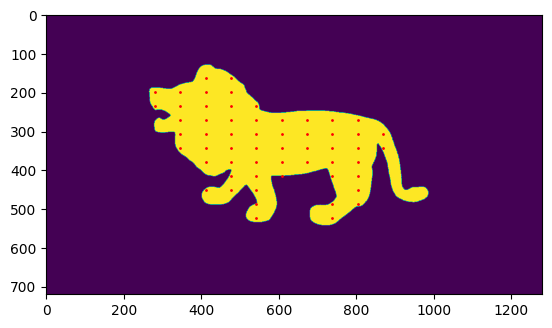

In [5]:
aligner = PixelToGaussianAligner(mask_path=MASK_PATH, pixeltracker_path=PIXELTRACKER_RESULTS_PATH, pixeltracker_upscale=UPSCALE, gaussian_object=gaussian_object, initial_cam_K=camKs[0], initial_R=initial_R, initial_T=initial_T)
mask: np.ndarray = aligner.mask
frame: np.ndarray = aligner.tracks[0]

# Plot mask and overlap tracked points
plt.imshow(mask)
plt.scatter(frame[:, 0], frame[:, 1], c='r', s=1)

### 1.3 Run aligner

We now do ray intersection originating at the pixel locations with the Gaussian splat model to see what exactly those pixels are attempting to follow in the Gaussian splat.

In [6]:
from posingpixels.visualization import get_points_pointcloud


intersections, filtered_tracks = aligner.align()

intersections_pointcloud = get_points_pointcloud(np.array(intersections))
object_pointcloud = get_gaussian_splat_pointcloud(gaussian_object)
plot_pointclouds({"Lion": object_pointcloud, "Intersections": intersections_pointcloud}, "Aligned Pixels in Gaussian Object")

100%|██████████| 58/58 [00:03<00:00, 15.03it/s]


In [7]:
from posingpixels.utils.geometry import apply_pose_to_ray, revert_pose_to_ray

print(initial_T)
ray_dir = pixel_to_ray_dir(np.array([477, 450]), camKs[0])
ray_origin, ray_dir = revert_pose_to_ray(np.zeros(3), ray_dir, initial_R, initial_T)
ray_pointcloud = get_ray_pointcloud(ray_origin, ray_dir, 0.4, 70)
lion_pointcloud = get_gaussian_splat_pointcloud(gaussian_object)
plot_pointclouds({"Lion": lion_pointcloud, "Ray": ray_pointcloud}, "Pointcloud of the lion and a ray")

[-0.00490763 -0.01135247  0.2955913 ]


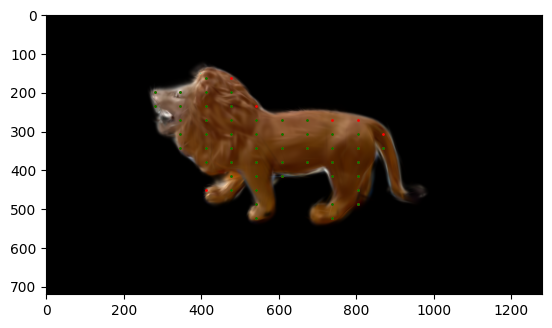

In [8]:
from posingpixels.utils.gs_pose import render_gaussian_model
import cv2

render = render_gaussian_model(gaussian_object, camKs[0], initial_R, initial_T, H, W)

# video_frame = cv2.addWeighted(cv2.cvtColor(render, cv2.COLOR_BGR2HSV), 0.6, video[0], 0.4, 1)

# plt.imshow(cv2.cvtColor(video_frame, cv2.COLOR_HSV2RGB))

# plt.imshow(video[0])

# plt.scatter(x=[411, 477], y=[450, 450], c='r', s=10)

plt.imshow(render)

plt.scatter(x=aligner.tracks[0][:, 0], y=aligner.tracks[0][:, 1], c='r', s=1)
plt.scatter(x=filtered_tracks[0][:, 0], y=filtered_tracks[0][:, 1], c='g', s=1)